In [2]:
import galsim
import numpy as np
import matplotlib
import pylab
import os
import matplotlib.pyplot as plt
import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"

from scipy.interpolate import CubicSpline

## Initialize some simple galaxy profile using GalSim (https://galsim-developers.github.io/GalSim/_build/html/index.html#)

In [3]:
#input galaxy params
gal_flux = 1.e5
gal_sigma = 1.
e1 = 0.1
e2 = 0.
pixel_scale=0.2

#some simple input galaxy model
gal = galsim.Gaussian(flux=gal_flux, sigma=gal_sigma)
gal = gal.shear(g1=e1, g2=e2)

In [4]:
# draw this to an image, and plot

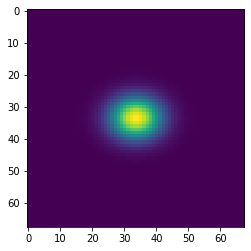

In [18]:
%matplotlib inline
#galaxy image

fig,ax=plt.subplots()
gal_im = gal.drawImage(scale=0.2)
ax.imshow(gal_im.array)

## Measure the ellipticity

# Use quadrulpole moments:

# First find centroid:
# $[\bar{x_1},\bar{x_2}] = \frac{\int \mathrm{d}^2{x} I(x_1,x_2) [x_1,x_2]}{\int  \mathrm{d}^2{x} I(x_1,x_2)} $

# Then compute quadrupole moments (c.f. variance = 2nd moment of PDF):
# $Q_{ij} =  \frac{\int \mathrm{d}^2{x} I(x_1,x_2)[x_i-\bar{x_i},x_j-\bar{x_j}]}{\int  \mathrm{d}^2{x} I(x_1,y_2)}$

# Now define ellipticity:
# $e_1 = \frac{Q_{11} - Q_{22}}{Q_{11} + Q_{22} + 2\sqrt{Q_{11}Q_{22}-Q_{12}^2}}$, $e_2 = \frac{Q_{12}}{Q_{11} + Q_{22} + 2\sqrt{Q_{11}Q_{22}-Q_{12}^2}}$

In [21]:
def get_centroid(gal_im):
    X,Y = np.meshgrid(np.arange(gal_im.shape[0]), np.arange(gal_im.shape[1]))
    denom = np.sum(gal_im)
    return (np.sum(gal_im*X)/denom, np.sum(gal_im*Y)/denom)

def get_second_moments(gal_im):
    X,Y = np.meshgrid(np.arange(gal_im.shape[0]), np.arange(gal_im.shape[1]))
    xbar,ybar = get_centroid(gal_im)
    denom = np.sum(gal_im)
    Qxx = np.sum( gal_im * (X-xbar)**2 )
    Qyy = np.sum( gal_im * (Y-ybar)**2 )
    Qxy = np.sum( gal_im * (X-xbar) * (Y-ybar) )
    return Qxx, Qyy, Qxy

def get_shape(gal_im):
    Qxx, Qyy, Qxy = get_second_moments(gal_im)
    e1_num = (Qxx - Qyy)
    e2_num = 2*Qxy
    denom = Qxx + Qyy + 2*np.sqrt(Qxx*Qyy - Qxy**2)
    return (e1_num/denom, e2_num/denom)

In [22]:
print(get_shape(gal_im.array))

(0.09966773955245671, -8.552438853584909e-08)
